In [1]:
import os
import sys
import time
import sqlite3
from Functions.database import createTable
import tensorboard as tf

from envConfig import CONFIG
CONFIG["PACKAGE_NAME"] = os.path.join(CONFIG["OUTPUTDATAPATH"], "Classification")

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import seaborn as sns


analysis_name = 'Classification'

data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


#db = sqlite3.connect(results_path+'classification.db')
#time = time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime())

In [2]:
from Functions.dataset.shipClasses import LoadData

dt_24 = LoadData(dev=True)
#dt_24.infoData()
all_data,all_trgt= dt_24.getData()

Using TensorFlow backend.


[+] Time to read data file: 4.55640602112 seconds


In [3]:
from Functions.preprocessing import CrossValidation

results_path_specific = results_path + '/dev' + '/HierNet/'
if not os.path.exists(results_path_specific):
    os.makedirs(results_path_specific)

cv = CrossValidation(X = all_data,y = all_trgt, estimator=None, n_folds=10, dev=True, verbose=1, dir=results_path_specific)



train_id, test_id, folder = cv.train_test_split(ifold=0)

File /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/10_folds_cross_validation_dev.jbl exists


In [4]:
from Functions.mlpClassification import MLPKeras
from Functions.preprocessing import CrossValidation,CVEnsemble
from Functions.ensemble import SpecialistClass,HierarqNet
import sklearn as sk



mlp = MLPKeras(hidden_layer_sizes=(40,),
                 activation=('tanh','tanh'),
                 optimize='adam',
                 lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False,
                 loss='mean_squared_error',
                 n_init=1,
                 batch_size=10,
                 epoch=10,
                 shuffle=True,
                 random_state=None,
                 verbose=False,
                 train_log = True,
                 append=False,
                 class_weight = True,
                 early_stopping = True,
                 monitor='sp', min_delta=0, patience=25,
                 mode='max', baseline=None, restore_best_weights=True,
                 save_best_model = True,
                 save_weights_only=False,
                 metrics=['acc','sp'],
                 validation_id=(None,None),
                 validation_fraction=0.2,
                 dir='./')

hn = HierarqNet(mlp,n_jobs=None,n_folds=10,verbose=True,dir=results_path_specific)

#cv = CrossValidation(mlp,all_data,all_trgt,n_folds=10,dev=False,verbose=False,dir=result_3Classes)

In [5]:
id_group = hn._fit_lvl1(mlp,X=all_data,y=all_trgt)


[+] training class super
Class 0 has 41.67% of 24000
Class 1 has 25.00% of 24000
Class 2 has 8.33% of 24000
Class 3 has 25.00% of 24000
File /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/10_folds_cross_validation.jbl exists
SP of folders already exists in /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/SP_folds.csv file
fold 7 has the highest sp value: 0.69
model already exists in /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/fold06/best_model.h5 file


In [23]:
for i in hn.estimators_.itervalues():
    print i[0].get_params()['dir'][:-7]

/home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/


In [6]:
#analysis of classifier S

_, _, y_new, ids = hn.estimators_['S']

ids = hn.estimators_['S'][-1]
index_per_class = np.array(range(all_trgt.shape[0]))
index = np.concatenate([index_per_class[ids[i]]for i in range(len(ids))])

df_index = pd.DataFrame({'index':index})

csv_anal = '/home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/fold00/hierarq_analy_fold_0.csv'
hierarq_anal = pd.read_csv(csv_anal)
df_tabela_S = pd.concat([df_index,hierarq_anal],axis=1)
df_tabela_S.head()



,index,HierarqNet(resultados)_0,HierarqNet(valor)_0,fold_0,target_0
0,0,2,-0.461570,1,0
1,1,3,0.813823,1,0
2,2,3,0.714165,1,0
3,3,1,0.537195,1,0
4,4,1,0.469561,1,0


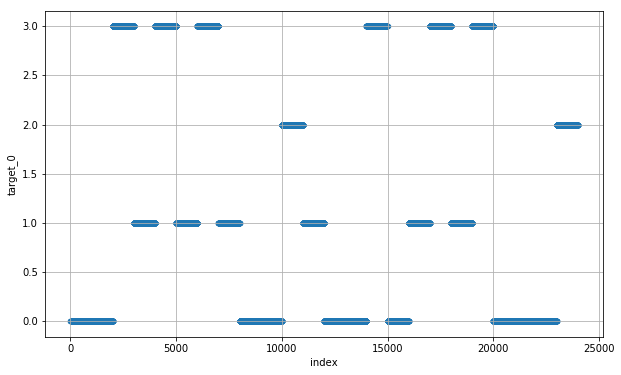

In [7]:


fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
df_tabela_S.plot(x='index',y='target_0',kind='scatter',ax=ax)
#plt.xticks(range(5000))
ax.grid()